# Megafon

**Data**: information about the response of subscribers to the proposal to connect one of the services. Also a normalized anonymized set of `features` characterizing the subscriber's consumption profile.

**Task**: a model that, for each **user-service** pair, determines the probability of connecting the service.

**Stack**: LightGBM, CatBoost, Sklearn, Dask, Pandas, Numpy, Matplotlib, Seaborn

<!-- Author: Ildar Khusainov - https://github.com/hildar -->

## Steps

1. First look at data
2. Baseline - LGBM
3. Features
4. Pipeline
5. Feature engineering
6. GridSearchCV
7. Conclusion

### First look at data

#### Read train test

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd  # for big file feature.csv ~20 Gb
import matplotlib.pyplot as plt
import datetime
import dill
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, f1_score, auc

import lightgbm

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # avoid warning

In [8]:
train = pd.read_csv('data/data_train.csv', index_col=0)
train.head(2)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 31.7 MB


#### Look at Target distribution

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

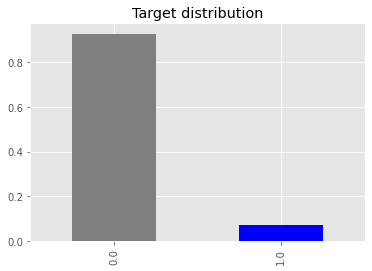

In [10]:
(train['target'].value_counts()/train['target'].shape[0]).\
    plot(kind='bar', title='Target distribution', color = ['grey', 'blue']);
train['target'].value_counts()/train['target'].shape

Not very balanced sample

In [11]:
test = pd.read_csv('data/data_test.csv', index_col=0)
test.head(2)

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


#### Common ids

There are extra indexes in the `feature.csv` file. Need to select rows without them.

In [13]:
train_ids = set(train.id.tolist())
test_ids = set(test.id.tolist())
common_ids = train_ids.union(test_ids)

print(f'Number train indexes: {len(train_ids)} \n\
Number test indexes: {len(test_ids)} \nNumber common indexes: {len(common_ids)}')

Number train indexes: 806613 
Number test indexes: 70152 
Number common indexes: 872577


#### Read features (~20 GB)

In [8]:
# features = dd.read_csv('data/features.csv', sep='\t')
# features

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
npartitions=351,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [9]:
# %%time
# features = features[features.id.isin(common_ids)].compute()
# features.head(2)

CPU times: user 8min 41s, sys: 1min 20s, total: 10min 2s
Wall time: 3min 53s


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
13,13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [10]:
# features.drop(columns='Unnamed: 0', inplace=True)
# features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 13 to 12844
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 1.7 GB


#### Save to parquet

Now we can save `features` in a binary file format - `Parquet`, and we can also delete large `CSV` files.

In [13]:
# %%time
# features.to_parquet('data/features_common_ids.parquet')

CPU times: user 6.53 s, sys: 1.84 s, total: 8.37 s
Wall time: 5.97 s


File size of `features_common_ids.parquet` ~200 Mb.

In [7]:
%%time
features = pd.read_parquet('data/features_common_ids.parquet')
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 13 to 12844
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 1.7 GB
CPU times: user 3.38 s, sys: 9.38 s, total: 12.8 s
Wall time: 4.97 s


#### Communication

In [14]:
def unique_ids(df):
    return df.groupby(by='id')['id'].agg('count').value_counts()

In [15]:
unique_ids(train)

1    781611
2     24964
3        38
Name: id, dtype: int64

In [16]:
unique_ids(test)

1    69092
2     1041
3       19
Name: id, dtype: int64

In [17]:
unique_ids(features)

1    842765
2     29812
Name: id, dtype: int64

Most of the indices are unique, but there are those that occur two or three times.

In [13]:
thrice_ids = train.groupby(by='id')['id'].agg('count')[train.groupby(by='id')['id'].agg('count') == 3].index.tolist()

In [14]:
tr_temp = train[train['id'].isin(set(thrice_ids) & common_ids)].head(100)
tr_temp.head(9)

,id,vas_id,buy_time,target
21564,1144355,4.0,1544994000,0.0
21565,1144355,4.0,1545598800,0.0
21566,1144355,6.0,1544994000,1.0
24239,3475168,1.0,1544994000,0.0
24240,3475168,4.0,1542574800,0.0
24241,3475168,6.0,1542574800,1.0
24631,271692,2.0,1543179600,0.0
24632,271692,4.0,1546203600,0.0
24633,271692,6.0,1546203600,1.0


There were several communications for these clients. This won't have much effect on our model, so let's leave it as it is.

### Baseline - LGBM

We use LightGBM for the baseline because it is fast and does not require extensive data preparation.

#### Time

Sorting the target variable by time and visualization

In [15]:
time_buy = pd.to_datetime(train[train['target'] == 1]['buy_time'], unit='s')\
                                                .sort_values(ascending=False).value_counts(sort=False)
time_notbuy = pd.to_datetime(train[train['target'] == 0]['buy_time'], unit='s')\
                                                .sort_values(ascending=False).value_counts(sort=False)


In [16]:
def plot_distribution(buy, notbuy, fig_size=(14, 6), width=2, 
                      set_axis=False, modifided_axis=[0.0, 10.5, 0.0, 105000.0],
                      title='Distribution of purchases', ylabel='Count of targets', xlabel='buy_time'):
    plt.figure(figsize=fig_size)
    plt.bar(notbuy.index, notbuy, width=width, color='grey', alpha=0.9)
    plt.bar(buy.index, buy, width=width*2, color='b', alpha=0.6)
    if set_axis:
        plt.axis(modifided_axis)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.yscale('log')
    plt.show()

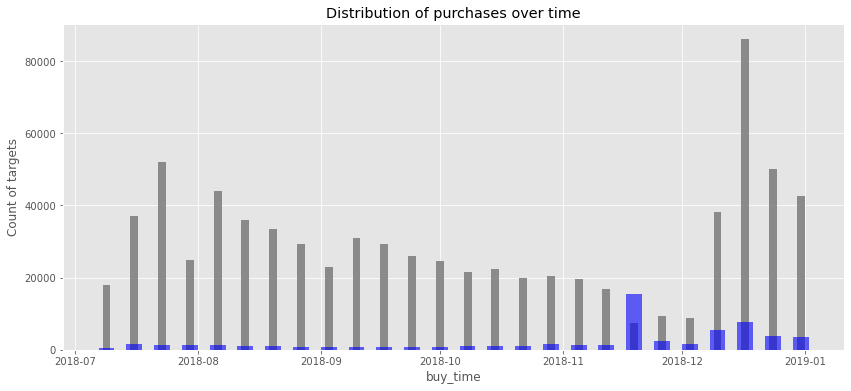

In [17]:
plot_distribution(time_buy, time_notbuy, title='Distribution of purchases over time')

Seasonal distribution of purchases and **peak** sales on the same day in November (Sale). Using **incomplete** seasonal data to evaluate the model is not the best solution. But it's a challenge.

We can try to make the **last month** (December) as a validation sample

#### Train valid split

As mentioned earlier, let's try to make the last month (December) as a test sample

In [25]:
SPLIT_DATE = np.datetime64('2018-12-01T00:00:00').astype(np.int64)
SPLIT_DATE

1543622400

In [26]:
def train_valid_split(train, split_date, drop_columns='target'):
    X_train = train[train['buy_time'] < split_date].copy(deep=True)
    X_val = train[train['buy_time'] >= split_date].copy(deep=True)

    y_train = X_train['target']
    y_val = X_val['target']

    X_train.drop(columns=drop_columns, inplace=True)
    X_val.drop(columns=drop_columns, inplace=True)
    
    return X_train, y_train, X_val, y_val

In [21]:
%%time
X_train, y_train, X_val, y_val = train_valid_split(train, SPLIT_DATE)

CPU times: user 44.7 ms, sys: 21.2 ms, total: 65.9 ms
Wall time: 68.9 ms


In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((584073, 3), (584073,), (247580, 3), (247580,))

#### Fit

In [23]:
%%time
lgb = lightgbm.LGBMClassifier(objective='binary', random_state=1)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_val)

CPU times: user 8.51 s, sys: 245 ms, total: 8.75 s
Wall time: 1.39 s


In [24]:
train_preds[:, 1]

array([0.01640412, 0.01091588, 0.01395224, ..., 0.01535436, 0.01161617,
       0.01263035])

In [25]:
f1_score(y_val, train_preds[:, 1] > 0.5, average='macro')

0.7271900451361183

#### Best threshold

Looking for the best threshold

In [72]:
def find_best_threshold(y_true, y_pred, do_print=False, macro=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # avoid zeros
    precision[precision == 0] = 1e-9
    recall[recall == 0] = 1e-9
    
    if macro:
        # average = 'macro'. This work slowly ~ 15 sec.
        fscore = []
        for th in np.linspace(0, 1, 101):
            fscore.append(f1_score(y_true, y_pred >= th, average='macro'))
        fscore = np.asarray(fscore)
    else:
        # average = 'binary'. This work fast.
        fscore = (2 * precision * recall) / (precision + recall)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix]
    if do_print:
        print(f'Best Threshold = {best_threshold:.3f}, F-Score = {fscore[ix]:.3f}, \
Precision = {precision[ix]:.3f}, Recall = {recall[ix]:.3f}')
    return best_threshold

In [27]:
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True)

Best Threshold = 0.252, F-Score = 0.575, Precision = 0.420, Recall = 0.914


In [28]:
f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')

0.7524529531176972

In [29]:
%%time
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True, macro=True)

Best Threshold = 0.305, F-Score = 0.753, Precision = 0.426, Recall = 0.880
CPU times: user 1min 16s, sys: 1.61 s, total: 1min 18s
Wall time: 1min 19s


In [30]:
f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')

0.7530341580965332

Despite the fact that the **threshold** was found for different `averages`=**binary/macro**, the final metric is almost the **same**. But the calculation time is very different.

In [31]:
print(classification_report(y_val, train_preds[:, 1] >= best_threshold))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    225378
         1.0       0.43      0.88      0.57     22202

    accuracy                           0.88    247580
   macro avg       0.71      0.88      0.75    247580
weighted avg       0.94      0.88      0.90    247580



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

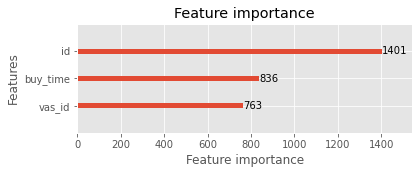

In [32]:
lightgbm.plot_importance(lgb, figsize=(6, 2))

Look at the `vas_id` feature

In [33]:
vas_buy = train[train['target'] == 1].groupby('vas_id')['vas_id'].agg('count')
vas_notbuy = train[train['target'] == 0].groupby('vas_id')['vas_id'].agg('count')

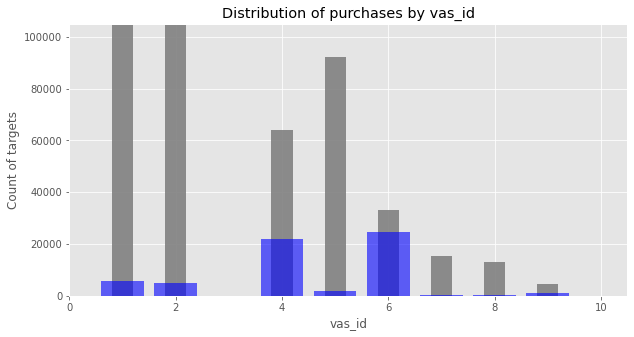

In [34]:
plot_distribution(vas_buy, vas_notbuy, fig_size=(10, 5), width=0.4, 
                      set_axis=True, modifided_axis=[0.0, 10.5, 0.0, 105000.0],
                      title='Distribution of purchases by vas_id', xlabel='vas_id')

`vas_id` can still be explained by the **influence** of services **4** and **6**, because they are **most** often connected. But how **interestingly** the `id` affects the model.

#### Visualisation. ROC Curve, PR Curve

In [3]:
def plot_roc_pr_curve(y_true, y_pred, model_name="Noname", color='b'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # plot ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    ax1.plot(fpr, tpr, label='%s: ROC Curve (area = %0.3f)' %
             (model_name, auc(fpr, tpr)), color=color)
    ax1.axis([0.0, 1.0, 0.0, 1.05])
    ax1.plot([0, 1], [0, 1], 'r--')  # diagonal
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")
    
    # plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    ax2.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.3f)' %
             (model_name, auc(recall, precision)), color=color)
    ax2.axis([-0.05, 1.05, 0.0, 1.05])
    # ax2.plot([0.8, 0.8], [0, 1], 'g--')  # best Recall
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title("Precision-Recall curve")
    ax2.legend(loc="lower left")

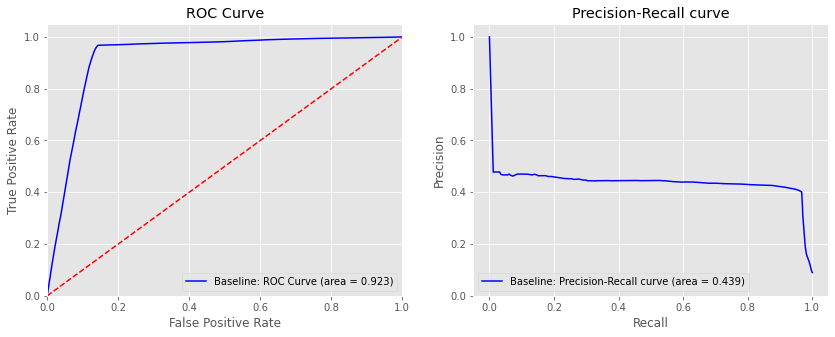

In [36]:
plot_roc_pr_curve(y_val, train_preds[:, 1], "Baseline", color='b')

#### Conclusion for baseline:

Not so bad performance for the baseline. As can be seen from the plot of the **PR Curve**, it is easy to find ~90% **Recall** for this model without compromising the **Precision**.

### Features

Let's look at the **features** and process them

#### Perform an asof merge.

In [29]:
# feature time it's time of update information about client
features.rename( columns={'buy_time':'update_info_time' } ,inplace=True) 

In [38]:
def merge_asof(left, right, ids):
    left = pd.merge_asof(left.sort_values(by=['buy_time']), 
                         right[features.id.isin(ids)].sort_values(by=['update_info_time']), 
                         left_on='buy_time', 
                         right_on='update_info_time', 
                         by='id',
                         direction='nearest'  # with nearest time
                         )
    return left

In [39]:
%%time
train = merge_asof(train, features, train_ids)
train.head(2)

CPU times: user 7.07 s, sys: 13.7 s, total: 20.8 s
Wall time: 30.6 s


,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,1544994000,314.560029,9.290888,342.989214,7.523202,337.571754,...,6488.626154,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0
1,1292549,2.0,1531083600,0.0,1537131600,93.880029,-217.499112,79.939214,-270.106798,74.521754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [40]:
%%time
test = merge_asof(test, features, test_ids)
test.head(2)

CPU times: user 791 ms, sys: 2.64 s, total: 3.43 s
Wall time: 5.09 s


,id,vas_id,buy_time,update_info_time,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,1546808400,1536526800,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,...,-464.373846,-104.770792,-25.996269,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0
1,31619,2.0,1546808400,1536526800,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [34]:
# train.to_parquet('data/train.parquet')
# test.to_parquet('data/test.parquet')

In [30]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')

#### Run learn function

Let's try to learn model with `features` and without feature engineering

In [31]:
%%time
X_train, y_train, X_val, y_val = train_valid_split(train, SPLIT_DATE)

CPU times: user 2.48 s, sys: 8.39 s, total: 10.9 s
Wall time: 16.1 s


In [32]:
def run_learn(X_train, y_train, X_val, y_val, model, slpit_date=SPLIT_DATE, plot_name='Noname'):
    # models
    model.fit(X_train, y_train)
    train_preds = model.predict_proba(X_val)

    # metrics
    best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True)
    f1_best = f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')
    f1 = f1_score(y_val, train_preds[:, 1] > 0.5, average='macro')
    
    print(f'F1-Score (average="macro") best threshold = {f1_best}')
    print(f'F1-Score (average="macro") threshold - 0.5 = {f1}\n')
    
    plot_roc_pr_curve(y_val, train_preds[:, 1], plot_name, color='b')
    
    return model

In [33]:
lgb = lightgbm.LGBMClassifier(objective='binary', random_state=1)

Best Threshold = 0.260, F-Score = 0.576, Precision = 0.421, Recall = 0.910
F1-Score (average="macro") best threshold = 0.7526978806388435
F1-Score (average="macro") threshold - 0.5 = 0.7123943450736683

CPU times: user 1min 10s, sys: 10.1 s, total: 1min 20s
Wall time: 26.5 s


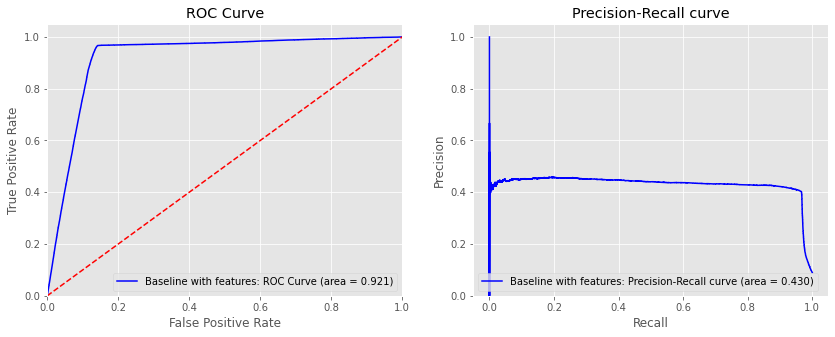

In [47]:
%%time
lgb = run_learn(X_train, y_train, X_val, y_val, lgb, slpit_date=SPLIT_DATE, plot_name='Baseline with features')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

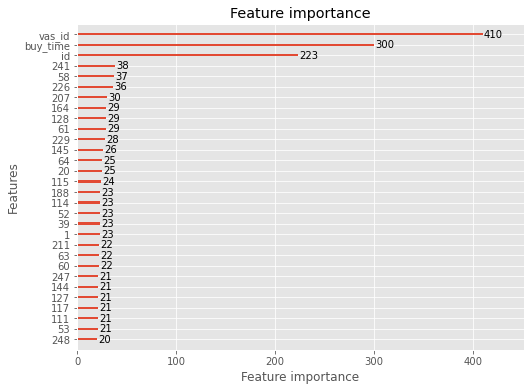

In [48]:
lightgbm.plot_importance(lgb, figsize=(8, 6) , max_num_features=30)

The scores **haven't changed** much. There is no strong influence of `features`.

#### Dublicates

In [35]:
%%time
f = features.copy()
f.set_index('id', inplace=True)

print("Are there duplicates in the rows? --> ", f.duplicated().sum())
print("What percentage features can be Null? --> %d%%" % float((f.isnull().sum() > 0).sum()/f.shape[1]*100))

Are there duplicates in the rows? -->  1422
What percentage features can be Null? --> 0%
CPU times: user 9.49 s, sys: 10.8 s, total: 20.2 s
Wall time: 27.2 s


In [36]:
%%time
f_duplicated = f[f.duplicated()]
f_duplicated.shape

CPU times: user 7.08 s, sys: 3.32 s, total: 10.4 s
Wall time: 11.3 s


(1422, 254)

In [37]:
f_dupl_ids = set(f_duplicated.index.tolist())
len(f_dupl_ids)

1418

In [38]:
print(f'There are duplicate indexes for the train dataset: {len(f_dupl_ids.intersection(train_ids))}')

There are duplicate indexes for the train dataset: 1318


In [39]:
print(f'There are duplicate indexes for the test dataset: {len(f_dupl_ids.intersection(test_ids))}')

There are duplicate indexes for the test dataset: 103


In [54]:
f_duplicated.head(3)

,update_info_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
3121327,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1638049,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3494546,1546808400,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,-6.78366,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [55]:
train[train['id'].isin([3121327, 1638049])]

,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
171499,1638049,1.0,1533502800,0.0,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
172919,3121327,1.0,1533502800,0.0,1545598800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [56]:
train[train['id'].isin(list(f_dupl_ids.intersection(train_ids)))].shape

(1353, 258)

In [57]:
test[test['id'].isin(list(f_dupl_ids.intersection(test_ids)))].shape

(106, 257)

This looks very **strange**. How can two persons be exactly the same? There is **1422** that rows - **1353** for **train** and **106** for **test** datasets!

But ok, we can't **remove** data from the **test**. Let's look at data types.

#### Data type of features

In [40]:
# these steps don't need a date
f.drop(columns='update_info_time', inplace=True) 
F_nunique = f.apply(lambda x: x.nunique())

In [41]:
F_nunique.sort_values().head(10)

81     1
85     1
139    1
75     1
203    1
197    2
196    2
26     2
27     2
31     2
dtype: int64

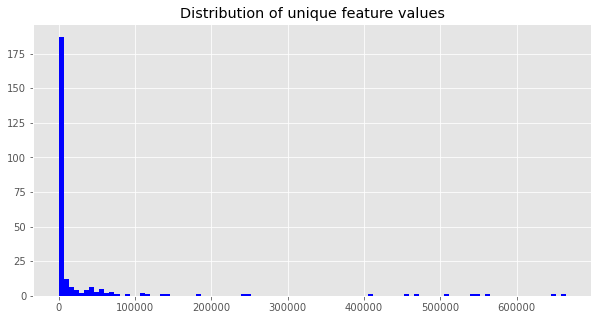

In [60]:
plt.title("Distribution of unique feature values");
F_nunique.hist(bins=100, figsize=(10, 5), color='b');

In [42]:
f_all = set(F_nunique.index.tolist())
len(f_all)

253

#### Constant features

In [43]:
f_const = set(F_nunique[F_nunique == 1].index.tolist())
len(f_const)

5

In [44]:
f_const

{'139', '203', '75', '81', '85'}

In [45]:
f[list(f_const)].head(2)

,81,85,203,75,139
id,,,,,
2046132,0.0,0.0,0.0,0.0,0.0
2050810,0.0,0.0,0.0,0.0,0.0


Constant features aren't needed. Let's **delete** them

#### Binary features

In [46]:
f_binary = set(F_nunique[F_nunique == 2].index.tolist())
len(f_binary)

20

In [47]:
train[list(f_binary)][list(f_binary)[0]].value_counts()

-0.00003    831632
 0.99997        21
Name: 33, dtype: int64

In [48]:
train[list(f_binary)][list(f_binary)[1]].value_counts()

-0.251959    620625
 0.748041    211028
Name: 196, dtype: int64

It's like **normalized** data with an offset. Let's not touch them.

In [49]:
f_other = f_all - (f_const | f_binary)
len(f_other)

228

#### Categorical features

In [50]:
f_categorical = set(F_nunique.loc[list(f_other)][F_nunique.loc[list(f_other)] <= 10].index.tolist())
len(f_categorical)

9

In [51]:
train[list(f_categorical)][list(f_categorical)[0]].value_counts()

-0.00004    831646
 0.99996         3
 7.99996         1
 3.99996         1
 1.99996         1
 2.99996         1
Name: 218, dtype: int64

In [52]:
f_other = f_other - f_categorical
len(f_other)

219

#### Numeric features

In [53]:
f_numeric = (f[list(f_other)].astype(int).sum() - f[list(f_other)].sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

218

#### Other features

In [54]:
f_other = f_other - f_numeric
len(f_other), f_other

(1, {'252'})

In [55]:
assert(F_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical) + len(f_other))

In [56]:
print(f'f_all: {len(f_all)}\n')
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_other:', len(f_other))

f_ok = list(f_binary | f_categorical | f_numeric | f_other)
f_binary, f_categorical, f_numeric, f_other = list(f_binary), list(f_categorical), list(f_numeric), list(f_other)

f_all: 253

f_const: 5
f_binary: 20
f_categorical: 9
f_numeric: 218
f_other: 1


Let's look at this last feature

In [57]:
f[list(f_other)].value_counts().shape

(34,)

In [58]:
f[list(f_other)].value_counts()

252   
0.0       674453
1.0       227888
2.0            5
8.0            3
3.0            3
4.0            3
10.0           3
11.0           2
13.0           2
7.0            2
5.0            2
446.0          1
77.0           1
299.0          1
284.0          1
283.0          1
251.0          1
223.0          1
195.0          1
182.0          1
84.0           1
82.0           1
24.0           1
68.0           1
44.0           1
42.0           1
36.0           1
23.0           1
22.0           1
19.0           1
18.0           1
16.0           1
6.0            1
1743.0         1
dtype: int64

It **looks like** a categorical feature, with some very **rare** objects.

In [78]:
train[train['252'] >= 2].target.value_counts()

0.0    39
1.0     4
Name: target, dtype: int64

In [79]:
train[(train['252'] >= 2) & (train['target'] == 1)]

,id,vas_id,buy_time,target,update_info_time,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
320995,4123710,2.0,1536526800,1.0,1531688400,-96.799971,-24.699112,-110.740786,-77.306798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,2.0
412050,1809707,6.0,1538341200,1.0,1535922000,495.570029,186.730888,481.629214,134.123202,476.211754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,3.0
536191,3906738,4.0,1541970000,1.0,1536526800,540.910029,233.770888,526.969214,181.163202,521.551754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,11.0
651830,2215612,6.0,1544994000,1.0,1540155600,-96.799971,-399.699112,-110.740786,-452.306798,-114.038246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,182.0


Since there are **~10%** of targets equal to **1**, then we cannot easily equate these categories with the largest strata **[0, 1]**. If this column is divided into categories, then the matrix will be **too sparse**. It will be possible to try to remove outliers and make a **binary** feature.

#### Importances feature

Let's make **30 important** `features` for feature engineering from the LGBM model.

In [60]:
feature_imp = pd.DataFrame(zip(X_train.columns, lgb.feature_importances_,), 
                           columns=['feature', 'weight']).sort_values(by='weight', ascending=False)

In [81]:
f_imp = feature_imp.head(33).iloc[3:, :]['feature'].values.tolist()

In [82]:
assert len(set(f_imp) & set(f_binary + f_categorical + f_other)) == 0

### Pipeline

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#### Make pipeline

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame does not have next columns: %s" % cols_error)

In [6]:
f_main = ['id', 'vas_id', 'buy_time', 'update_info_time']

In [65]:
f_prep_pipeline = make_pipeline(
    FeatureUnion(transformer_list=[
        ("main_features", make_pipeline(
            ColumnSelector(f_main),
        )),
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        )),
        ("other_features", make_pipeline(
            ColumnSelector(f_other),
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

Save the feature pipeline since the kernel is dying due to large files

In [7]:
# with open('data/features_pipeline.dill', 'wb') as f:
#     dill.dump(f_prep_pipeline, f)

#### LGBM

In [66]:
lgb_pipe = make_pipeline(
    f_prep_pipeline,
    lightgbm.LGBMClassifier(objective='binary', random_state=1)
)

Best Threshold = 0.253, F-Score = 0.576, Precision = 0.420, Recall = 0.917
F1-Score (average="macro") best threshold = 0.7525469090834258
F1-Score (average="macro") threshold - 0.5 = 0.7094544362330713

CPU times: user 1min 30s, sys: 46.4 s, total: 2min 16s
Wall time: 1min 55s


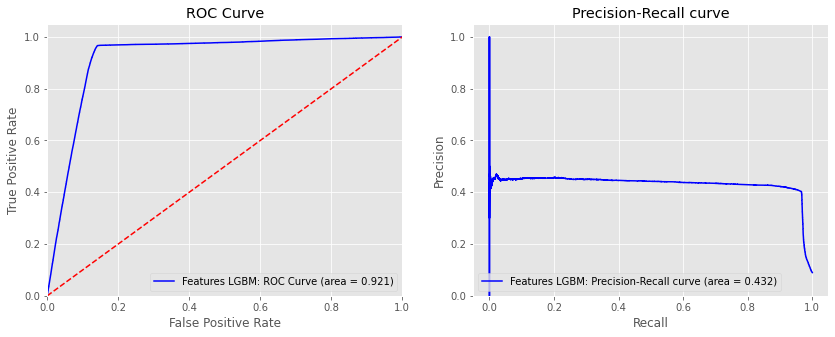

In [88]:
%%time
lgb_pipe = run_learn(X_train, y_train, X_val, y_val, lgb_pipe, slpit_date=SPLIT_DATE, plot_name='Features LGBM')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

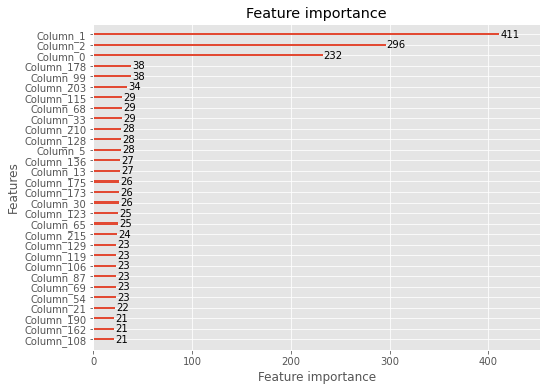

In [89]:
lightgbm.plot_importance(lgb_pipe[1], figsize=(8, 6) , max_num_features=30)

baseline shows **better** results

In [90]:
# [k for k in lgb_pipe.get_params().keys() if 'lgbmclassifier' in k]

#### Cat Boost

In [91]:
from catboost import CatBoostClassifier

In [92]:
catboost_pipe = make_pipeline(
    f_prep_pipeline,
    CatBoostClassifier(iterations=100, random_state=1)
)

In [93]:
# [k for k in catboost_pipe.get_params().keys() if 'verbose' in k]

In [94]:
# params = {'verbose': True,
#           'pipeline__verbose': True,
#           'catboostclassifier__iterations': 100
#          }

In [95]:
# catboost_pipe.set_params(**params)

Learning rate set to 0.5
0:	learn: 0.2091548	total: 251ms	remaining: 24.9s
1:	learn: 0.1539980	total: 463ms	remaining: 22.7s
2:	learn: 0.1422695	total: 669ms	remaining: 21.6s
3:	learn: 0.1402910	total: 874ms	remaining: 21s
4:	learn: 0.1386464	total: 1.01s	remaining: 19.3s
5:	learn: 0.1379822	total: 1.16s	remaining: 18.2s
6:	learn: 0.1377790	total: 1.29s	remaining: 17.1s
7:	learn: 0.1375881	total: 1.41s	remaining: 16.3s
8:	learn: 0.1374404	total: 1.54s	remaining: 15.6s
9:	learn: 0.1373471	total: 1.7s	remaining: 15.3s
10:	learn: 0.1373180	total: 1.82s	remaining: 14.7s
11:	learn: 0.1372517	total: 1.93s	remaining: 14.2s
12:	learn: 0.1371674	total: 2.06s	remaining: 13.8s
13:	learn: 0.1371049	total: 2.18s	remaining: 13.4s
14:	learn: 0.1370545	total: 2.3s	remaining: 13s
15:	learn: 0.1370071	total: 2.44s	remaining: 12.8s
16:	learn: 0.1369935	total: 2.55s	remaining: 12.5s
17:	learn: 0.1369209	total: 2.72s	remaining: 12.4s
18:	learn: 0.1368788	total: 2.85s	remaining: 12.2s
19:	learn: 0.1368350	t

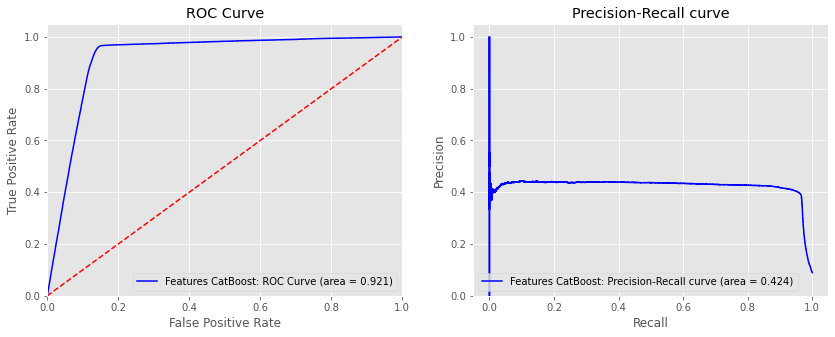

In [96]:
%%time
catboost_pipe = run_learn(X_train, y_train, X_val, y_val, catboost_pipe, 
                          slpit_date=SPLIT_DATE, plot_name='Features CatBoost')

No significant changes.

#### Logreg

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
f_prep_pipeline_logreg = make_pipeline(
    FeatureUnion(transformer_list=[
        ("main_features", make_pipeline(
            ColumnSelector(f_main),
        )),
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler()  # for logreg need scaler
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        )),
        ("other_features", make_pipeline(
            ColumnSelector(f_other),
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [99]:
logreg_pipe = make_pipeline(
    f_prep_pipeline_logreg,
    LogisticRegression(random_state=1)
)

Best Threshold = 0.066, F-Score = 0.166, Precision = 0.092, Recall = 0.834
F1-Score (average="macro") best threshold = 0.23918025448966912
F1-Score (average="macro") threshold - 0.5 = 0.4765285712473412

CPU times: user 43.2 s, sys: 25 s, total: 1min 8s
Wall time: 1min 21s


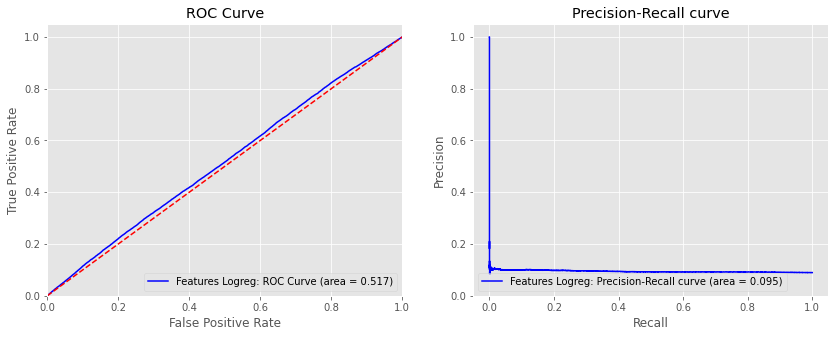

In [100]:
%%time
logreg_pipe = run_learn(X_train, y_train, X_val, y_val, logreg_pipe, slpit_date=SPLIT_DATE, plot_name='Features Logreg')

LogisticRegression not working **at all**. Let's see correlations with main `features`

In [101]:
import seaborn as sns

<AxesSubplot:>

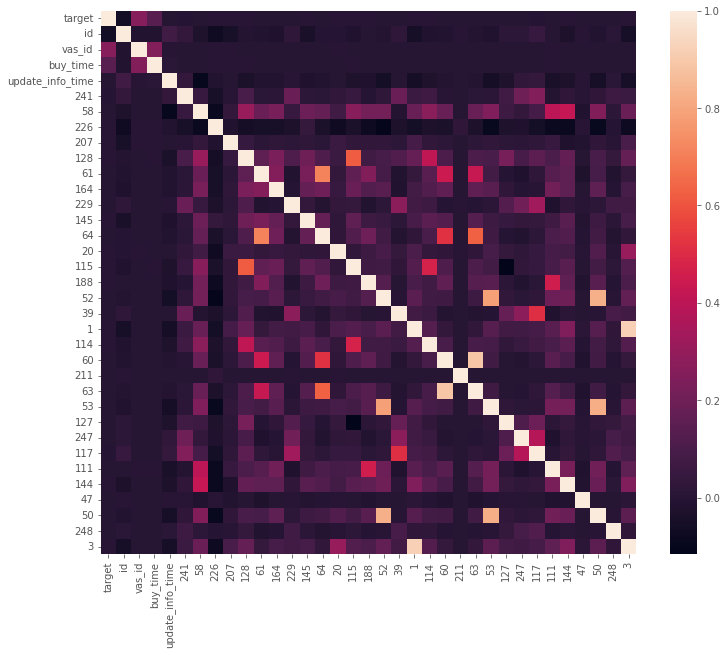

In [104]:
plt.figure(figsize=(12, 10))
sns.heatmap(train[['target'] + f_main + f_imp].corr())

Yes, very **weak correlation** with the `target`. Logreg in such cases does not work very well. There is also multicolleniality in the data.

### Feature engineering

#### Pairwise features

##### $H_1$  uset-item

Ok. Let's try make new features. Since the condition of the task is to find the probability for **user-item pairs**, the creation of paired `features` will probably help.

Let's call it hypothesis $H_1$

In [230]:
# Get new feature 
def get_feature(df, group_by, agg_col, agg_func, denominator_flag=False, denominator_num='column_name'):
    # base value of denominator
    denominator = 1
    
    # if flag == true then calculate number of unique value for denominator
    if denominator_flag:
        denominator = df[denominator_num].nunique()
    
    # return new column as Series 
    return df.merge(df.groupby(by=group_by)[agg_col].agg(agg_func)\
                         .rename('new_feature')/denominator, 
                         how='left', 
                         on=group_by).iloc[:, -1].fillna(0).to_numpy()

In [190]:
X_train[f_imp].head(2)

,241,58,226,207,128,61,164,229,145,64,...,53,127,247,117,111,144,47,50,248,3
0,508.382022,2.318354,5.613617,1482.274176,0.244871,-0.178162,0.090492,193.871014,43.03637,-0.265662,...,-25.331295,0.039549,142.252276,-2298.725139,-0.62084,-64.720802,-4.418641,-2.130284,-16.832889,7.523202
1,-106.617978,-10.681646,14.399332,-11953.712824,-0.575129,-0.028162,-0.089508,-266.128986,-20.96363,-0.005662,...,-24.331295,-0.060451,-306.747724,-2298.725139,5.37916,-51.754142,-5.785383,-25.130284,-25.832889,-270.106798


In [161]:
train['user_item_241_sum'] = get_feature(train, ['id', 'vas_id'], '241', 'sum')

In [163]:
train['user_item_241_cnt'] = get_feature(train, ['id', 'vas_id'], 'id', 'count')

In [167]:
train['241'].value_counts()

-106.617978     386370
-105.617978      21129
-104.617978      14854
-103.617978       9245
-92.617978        8705
                 ...  
 3847.382022         1
 2905.382022         1
 5451.382022         1
 3272.382022         1
 4091.382022         1
Name: 241, Length: 4706, dtype: int64

In [168]:
train['user_item_241_sum'].value_counts()

-106.617978     380458
-105.617978      20783
-104.617978      14641
-103.617978       9093
-92.617978        8586
                 ...  
 3963.382022         1
 5526.382022         1
 5272.382022         1
 2187.382022         1
 4091.382022         1
Name: user_item_241_sum, Length: 5407, dtype: int64

In [165]:
train['user_item_241_cnt'].value_counts()

1.0    819155
2.0     12498
Name: user_item_241_cnt, dtype: int64

In [164]:
train[['241', 'user_item_241_sum', 'user_item_241_cnt']]

,241,user_item_241_sum,user_item_241_cnt
0,508.382022,508.382022,1.0
1,-106.617978,-106.617978,1.0
2,80.382022,80.382022,1.0
3,-35.617978,-35.617978,1.0
4,-106.617978,-106.617978,1.0
...,...,...,...
831648,-106.617978,-106.617978,1.0
831649,-106.617978,-106.617978,1.0
831650,-106.617978,-106.617978,1.0
831651,-106.617978,-106.617978,1.0


In [154]:
train['id'].value_counts().value_counts()

1    781611
2     24964
3        38
Name: id, dtype: int64

In [152]:
train[['id', 'target']].groupby('target')['target'].count()

target
0.0    771467
1.0     60186
Name: target, dtype: int64

In [160]:
train[['id', 'target']][train['target'] == 1].value_counts().value_counts()

1    59990
2       98
dtype: int64

Almost all `id`s have **unique** values, so pairing doesn't work.

For reliability, we will create a few more features and try to train the model

In [169]:
%%time
X_train['user_item_cnt'] = get_feature(X_train, ['id', 'vas_id'], 'id', 'count')

X_train['user_item_241_sum'] = get_feature(X_train, ['id', 'vas_id'], '241', 'sum')
X_train['user_item_58_sum'] = get_feature(X_train, ['id', 'vas_id'], '58', 'sum')
X_train['user_item_226_sum'] = get_feature(X_train, ['id', 'vas_id'], '226', 'sum')
X_train['user_item_207_sum'] = get_feature(X_train, ['id', 'vas_id'], '207', 'sum')
X_train['user_item_128_sum'] = get_feature(X_train, ['id', 'vas_id'], '128', 'sum')

CPU times: user 11.9 s, sys: 23 s, total: 34.9 s
Wall time: 51.5 s


It should be separate to avoid **dataleak**

In [231]:
%%time
X_val['user_item_cnt'] = get_feature(X_val, ['id', 'vas_id'], 'id', 'count')

X_val['user_item_241_sum'] = get_feature(X_val, ['id', 'vas_id'], '241', 'sum')
X_val['user_item_58_sum'] = get_feature(X_val, ['id', 'vas_id'], '58', 'sum')
X_val['user_item_226_sum'] = get_feature(X_val, ['id', 'vas_id'], '226', 'sum')
X_val['user_item_207_sum'] = get_feature(X_val, ['id', 'vas_id'], '207', 'sum')
X_val['user_item_128_sum'] = get_feature(X_val, ['id', 'vas_id'], '128', 'sum')

CPU times: user 5.22 s, sys: 4 s, total: 9.22 s
Wall time: 9.46 s


In [239]:
X_train.head(2)

,id,vas_id,buy_time,update_info_time,0,1,2,3,4,5,...,249,250,251,252,user_item_cnt,user_item_241_sum,user_item_58_sum,user_item_226_sum,user_item_207_sum,user_item_128_sum
0,2582523,2.0,1531083600,1544994000,314.560029,9.290888,342.989214,7.523202,337.571754,-13.58179,...,-0.694428,-11.175933,-0.45614,0.0,1.0,508.382022,2.318354,5.613617,1482.274176,0.244871
1,1292549,2.0,1531083600,1537131600,93.880029,-217.499112,79.939214,-270.106798,74.521754,-291.21179,...,-0.694428,-12.175933,-0.45614,0.0,1.0,-106.617978,-10.681646,14.399332,-11953.712824,-0.575129


Best Threshold = 0.235, F-Score = 0.575, Precision = 0.415, Recall = 0.936
F1-Score (average="macro") best threshold = 0.7514568751655348
F1-Score (average="macro") threshold - 0.5 = 0.7120371038602866

CPU times: user 1min 12s, sys: 11.7 s, total: 1min 24s
Wall time: 30.6 s


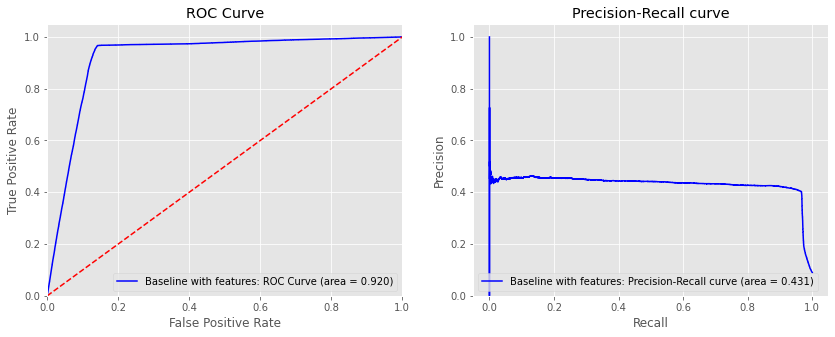

In [240]:
%%time
lgb = run_learn(X_train, y_train, X_val, y_val, lgb, slpit_date=SPLIT_DATE, plot_name='Baseline with features')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

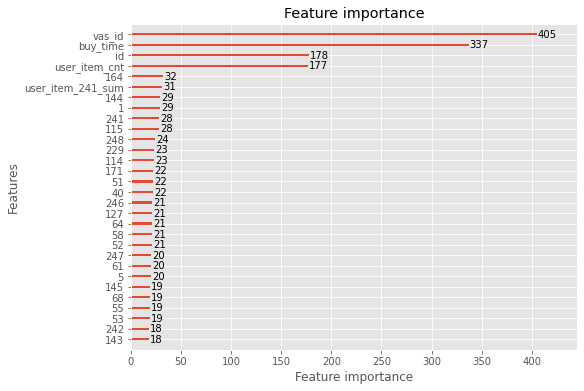

In [241]:
lightgbm.plot_importance(lgb, figsize=(8, 6) , max_num_features=30)

The metrics **did not change**. We reject the hypothesis $H_1$. 

We can try **power multiplication**, but this usually does not affect tree-based models because the **order** of the objects will remain the same.

##### $H_2$ time

Ok. Let's try to create some dependencies on `buy_time`. This feature has a strong impact and perhaps there is a deeper meaning. Modular arithmetic calculations: e.g. converting a timestamp into day of the month.

Let's call it hypothesis $H_2$

In [244]:
train['day'] = pd.to_datetime(train['buy_time'], unit='s').dt.day

In [245]:
X_train['day'] = pd.to_datetime(X_train['buy_time'], unit='s').dt.day
X_val['day'] = pd.to_datetime(X_val['buy_time'], unit='s').dt.day

In [247]:
X_train.head(2)

,id,vas_id,buy_time,update_info_time,0,1,2,3,4,5,...,250,251,252,user_item_cnt,user_item_241_sum,user_item_58_sum,user_item_226_sum,user_item_207_sum,user_item_128_sum,day
0,2582523,2.0,1531083600,1544994000,314.560029,9.290888,342.989214,7.523202,337.571754,-13.58179,...,-11.175933,-0.45614,0.0,1.0,508.382022,2.318354,5.613617,1482.274176,0.244871,8
1,1292549,2.0,1531083600,1537131600,93.880029,-217.499112,79.939214,-270.106798,74.521754,-291.21179,...,-12.175933,-0.45614,0.0,1.0,-106.617978,-10.681646,14.399332,-11953.712824,-0.575129,8


Best Threshold = 0.238, F-Score = 0.575, Precision = 0.415, Recall = 0.936
F1-Score (average="macro") best threshold = 0.7511984977375817
F1-Score (average="macro") threshold - 0.5 = 0.7016916632078252

CPU times: user 1min 8s, sys: 11.4 s, total: 1min 20s
Wall time: 30.3 s


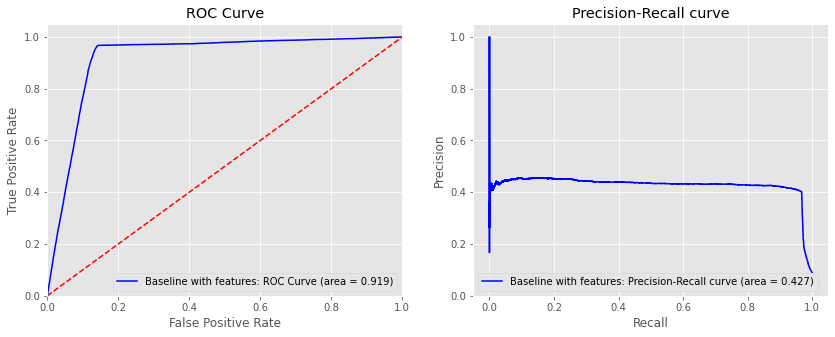

In [248]:
%%time
lgb = run_learn(X_train, y_train, X_val, y_val, lgb, slpit_date=SPLIT_DATE, plot_name='Baseline with features')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

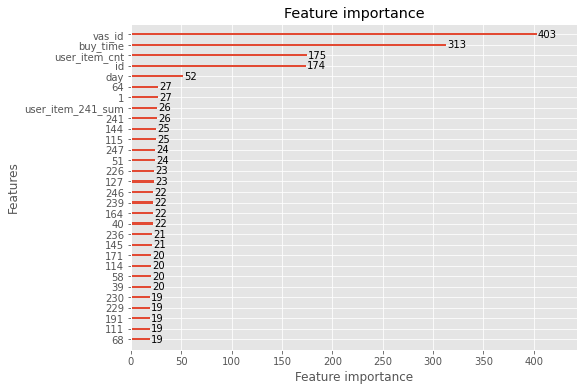

In [249]:
lightgbm.plot_importance(lgb, figsize=(8, 6) , max_num_features=30)

The metrics **did not change**. We reject the hypothesis $H_2$. 

#### Conclusion

Feuture engineering does not affect metrics, so let's just take a **lgbm pipeline**.

### GridSearchCV

In [7]:
train = pd.read_parquet('data/train.parquet')

In [8]:
X = train.drop(columns='target')
y = train['target']

In [9]:
with open('data/features_pipeline.dill', 'rb') as f:
    f_prep_pipeline = dill.load(f)

In [10]:
lgb_pipe = make_pipeline(
    f_prep_pipeline,
    lightgbm.LGBMClassifier(objective='binary', random_state=1)
)

#### GridSearch function

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

Time series data requires special cross-validation class

In [16]:
X.shape

(831653, 257)

In [49]:
tscv = TimeSeriesSplit(n_splits=3)

In [50]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1_macro'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, verbose=2)

    gsc.fit(X, y)
    print(f"Best {scoring} score: {gsc.best_score_:.2f}\n")
    print("Best parameters set found on development set:\n")
    print(gsc.best_params_, '\n')
    print("Grid scores on development set:\n")

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))
        
        print(f"{gsc.cv_results_['mean_test_score'][i]:.3f} \
(+/-{gsc.cv_results_['std_test_score'][i] * 2:.03f}) for {params}\n")
    
    return gsc

In [48]:
[k for k in lgb_pipe.get_params().keys() if 'lgbm' in k]

['lgbmclassifier',
 'lgbmclassifier__boosting_type',
 'lgbmclassifier__class_weight',
 'lgbmclassifier__colsample_bytree',
 'lgbmclassifier__importance_type',
 'lgbmclassifier__learning_rate',
 'lgbmclassifier__max_depth',
 'lgbmclassifier__min_child_samples',
 'lgbmclassifier__min_child_weight',
 'lgbmclassifier__min_split_gain',
 'lgbmclassifier__n_estimators',
 'lgbmclassifier__n_jobs',
 'lgbmclassifier__num_leaves',
 'lgbmclassifier__objective',
 'lgbmclassifier__random_state',
 'lgbmclassifier__reg_alpha',
 'lgbmclassifier__reg_lambda',
 'lgbmclassifier__silent',
 'lgbmclassifier__subsample',
 'lgbmclassifier__subsample_for_bin',
 'lgbmclassifier__subsample_freq']

In [51]:
param_grid = {
    "lgbmclassifier__n_estimators": [100, 200],
    "lgbmclassifier__max_depth": [8, -1],
    'lgbmclassifier__reg_alpha': [0, 0.1]
}

In [52]:
%%time
lgb_gsc = run_grid_search(lgb_pipe, X, y, param_grid, tscv)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0; total time=  24.8s
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0; total time=  38.3s
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0; total time= 1.0min
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0.1; total time=  22.6s
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0.1; total time=  38.3s
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=100, lgbmclassifier__reg_alpha=0.1; total time= 1.0min
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=200, lgbmclassifier__reg_alpha=0; total time=  22.9s
[CV] END lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=200, lgbmclassifier__reg_al

Save final pipeline

In [53]:
with open('data/lgb_gsc.dill', 'wb') as f:
    dill.dump(lgb_gsc, f)

In [59]:
with open('data/lgb_gsc.dill', 'rb') as f:
    lgb_gsc = dill.load(f)

#### Final check

In [27]:
%%time
X_train, y_train, X_val, y_val = train_valid_split(train, SPLIT_DATE)

CPU times: user 2.4 s, sys: 6.9 s, total: 9.29 s
Wall time: 12.1 s


In [54]:
train_preds = lgb_gsc.predict_proba(X_val)

In [55]:
f1_score(y_val, train_preds[:, 1] > 0.5, average='macro')

0.577270517801237

In [56]:
# average='binary'
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True)

Best Threshold = 0.352, F-Score = 0.594, Precision = 0.451, Recall = 0.869


In [57]:
f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')

0.7660697707840967

In [70]:
%%time

# # average='macro'
best_threshold = find_best_threshold(y_val, train_preds[:, 1], do_print=True, macro=True)

Best Threshold = 0.006, F-Score = 0.767, Precision = 0.239, Recall = 1.000
CPU times: user 10.8 s, sys: 307 ms, total: 11.2 s
Wall time: 11.2 s


In [71]:
f1_score(y_val, train_preds[:, 1] >= best_threshold, average='macro')

0.6001667837288863

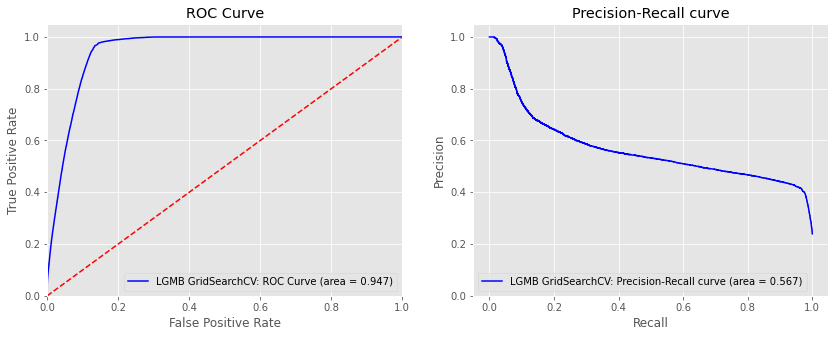

In [88]:
plot_roc_pr_curve(y_val, train_preds[:, 1], "LGMB GridSearchCV", color='b')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

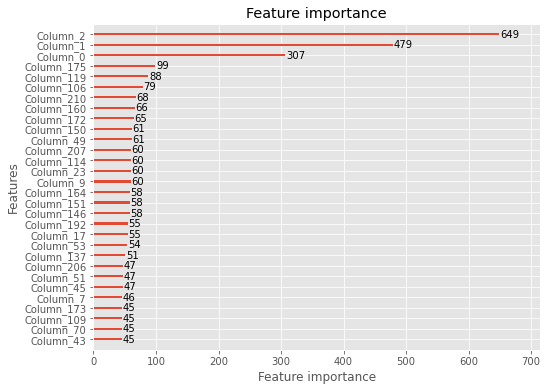

In [81]:
lightgbm.plot_importance(lgb_gsc.best_estimator_[1], figsize=(8, 6) , max_num_features=30)

#### Test.csv

In [104]:
# test data with features
test_feats = pd.read_parquet('data/test.parquet')

In [105]:
train_preds = lgb_gsc.predict_proba(test_feats)

In [108]:
answers = test_feats.iloc[:, :3]

In [119]:
answers['target'] = train_preds[:, -1]

In [122]:
answers.head(2)

,id,vas_id,buy_time,target
0,2905850,5.0,1546808400,0.000967
1,31619,2.0,1546808400,0.000194


In [123]:
answers.to_csv('data/answers_test.csv', index=False)

In [125]:
pd.read_csv('data/answers_test.csv').head(2)

,id,vas_id,buy_time,target
0,2905850,5.0,1546808400,0.000967
1,31619,2.0,1546808400,0.000194


### Conclusion

- GridSearch and cross-validation increased the **F-score** by 5% absolute percent.

- GridSearchCV also increased **Precision**. Now it is possible to get higher precision relative to **threshold**.

- By changing the **threshold**, it is possible to get a better **business** metric

- I didn't find any sense in `features`. The main **influence** is `buy_time` and `vas_id`.

- Logistic regression **failed**. Maybe this is due to the low correlation of `features` with the `target`.

- Feature engineering such as user-item grouping or time grouping does not provide improvements.